In [4]:
import matplotlib.pyplot as plt

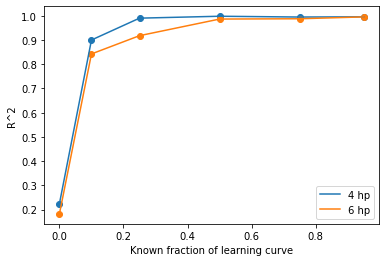

In [5]:
'''
r2 for different known fractions of the learning curve. Using 4hp vs 6hp search space
'''
lc = [0.0, 0.1, 0.25, 0.5, 0.75, 0.95]
#4hp_300
r2 = [0.22403961538598205, 0.8999997566529759, 0.9902491879059602, 0.9981281161265539,0.9948304924468403, 0.9957560886696417]
plt.scatter(lc,r2)
plt.plot(lc, r2,label="4 hp")
#6hp_300
r2 = [0.18199650749836238, 0.8425353570944493, 0.9178920638307584, 0.9865299976933071, 0.9877538295056862, 0.9954100184701985]
plt.scatter(lc,r2,)
plt.plot(lc, r2, label ="6 hp")
plt.xlabel("Known fraction of learning curve")
plt.ylabel("R^2")
plt.legend(loc="lower right")
plt.show()

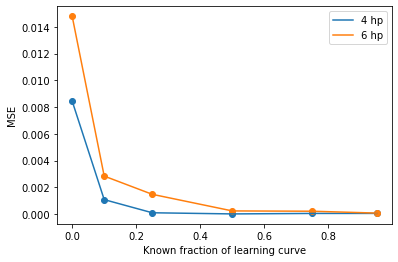

In [6]:
'''
mse of the performance predictor for different known fractions of the learning curve. Using 4hp vs 6hp search space
'''
lc = [0.0, 0.1, 0.25, 0.5, 0.75, 0.95]
#4hp_300
mse = [0.008452663555809713, 0.0010885464511665637, 0.00010614186071653187, 2.0376275889295854e-05, 5.627235407560785e-05, 5.782874930618936e-05]
plt.scatter(lc,mse)
plt.plot(lc, mse,label="4 hp")
#6hp_300
mse = [0.014791127486088108, 0.0028472734274574973, 0.001484674530893162, 0.00024356438961756308, 0.00022143508023885782, 8.299598056538616e-05]
plt.scatter(lc,mse)
plt.plot(lc, mse, label ="6 hp")
plt.xlabel("Known fraction of learning curve")
plt.ylabel("MSE")
plt.legend(loc="upper right")
plt.show()